In [150]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Загрузка данных

In [185]:
df = pd.read_csv(r'C:\Users\Anast.Andreeva1\.cache\kagglehub\datasets\uciml\german-credit\versions\1\german_credit_data.csv')

In [218]:
print(df.shape)
print(df.dtypes.value_counts())
print(df.columns.tolist())
print("="*140)
print(df.head())


(1000, 10)
int64     5
object    5
Name: count, dtype: int64
['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


# Пропуски

In [219]:
missing_pct = df.isnull().sum() / len(df) * 100
print(missing_pct[missing_pct > 0])

Saving accounts     18.3
Checking account    39.4
dtype: float64


In [220]:
print("\n" + "="*50)
print("ЧИСЛОВЫЕ ПРИЗНАКИ")
print("="*50)
print(df[['Age', 'Credit amount', 'Duration']].describe())


ЧИСЛОВЫЕ ПРИЗНАКИ
               Age  Credit amount     Duration
count  1000.000000    1000.000000  1000.000000
mean     35.546000    3271.258000    20.903000
std      11.375469    2822.736876    12.058814
min      19.000000     250.000000     4.000000
25%      27.000000    1365.500000    12.000000
50%      33.000000    2319.500000    18.000000
75%      42.000000    3972.250000    24.000000
max      75.000000   18424.000000    72.000000


In [221]:
print("\n" + "="*50)
print("КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ")
print("="*50)
cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    print(f"\n{col}:")
    counts_df = df[col].value_counts().reset_index().rename(columns={'index': 'Value', col: 'Count'})
    print(counts_df)



КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ

Sex:
    Count  count
0    male    690
1  female    310

Job:
   Count  count
0      2    630
1      1    200
2      3    148
3      0     22

Housing:
  Count  count
0   own    713
1  rent    179
2  free    108

Saving accounts:
        Count  count
0      little    603
1    moderate    103
2  quite rich     63
3        rich     48

Checking account:
      Count  count
0    little    274
1  moderate    269
2      rich     63

Purpose:
                 Count  count
0                  car    337
1             radio/TV    280
2  furniture/equipment    181
3             business     97
4            education     59
5              repairs     22
6  domestic appliances     12
7      vacation/others     12


# Визуал

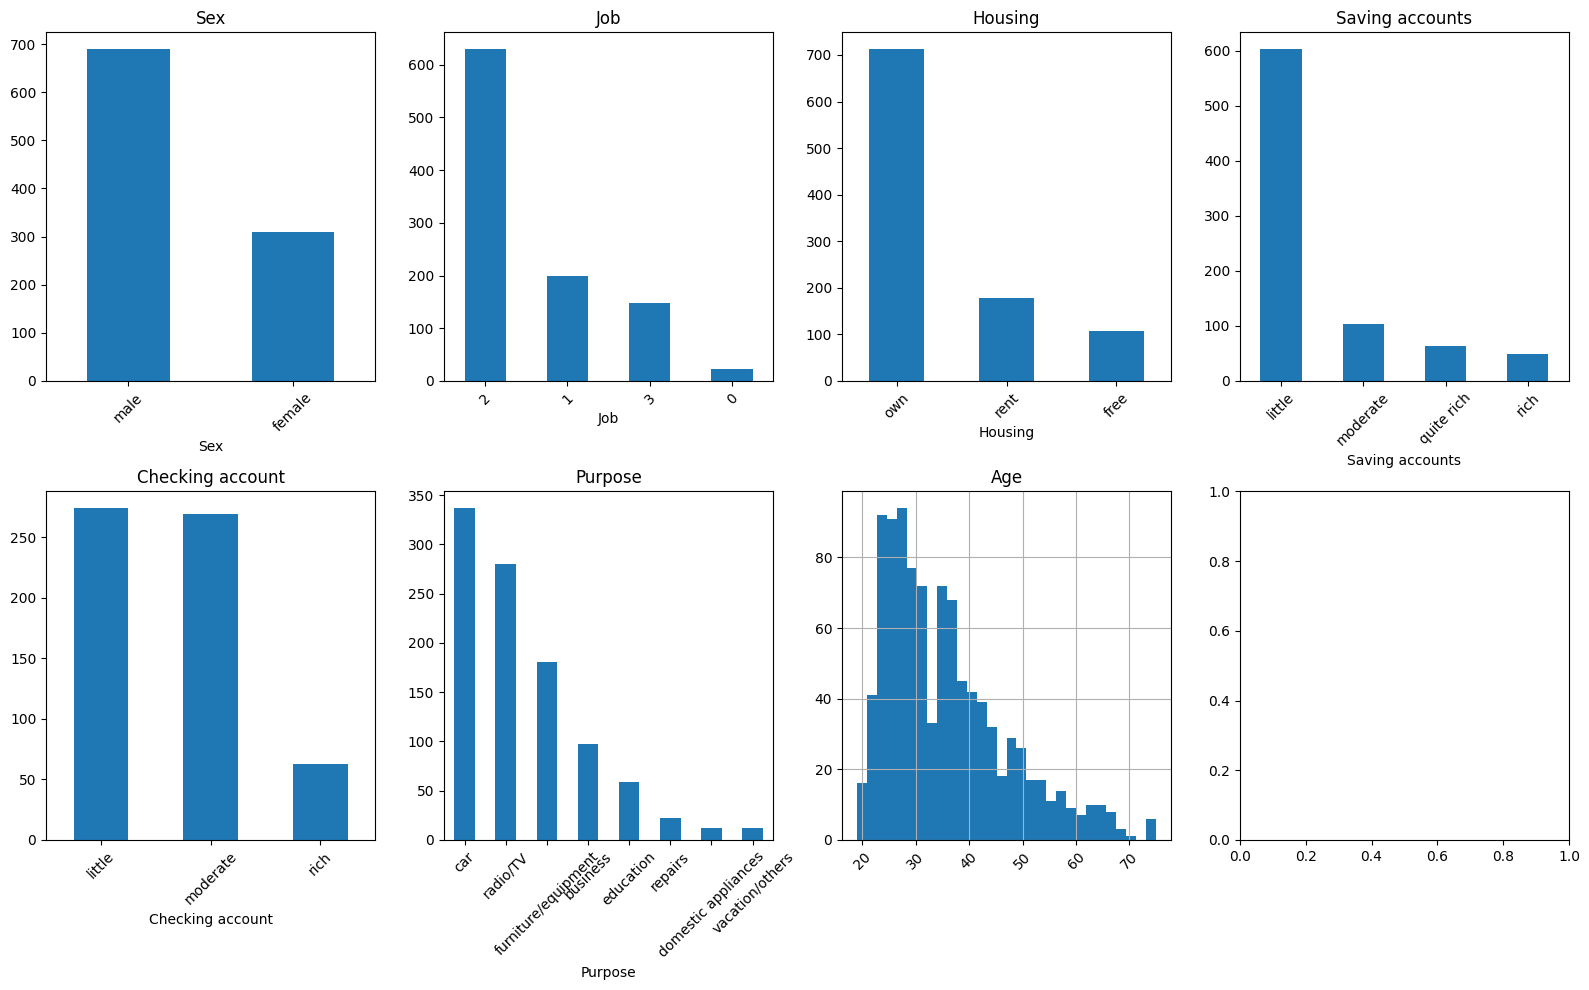

In [222]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(cat_cols + ['Age']):
    if col in cat_cols:
        df[col].value_counts().plot(kind='bar', ax=axes[i])
    else:
        df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Preprocessing

In [223]:
# Обработка пропусков 

df_processed = df.copy() # копия для обработки

In [224]:
# Заполняю пропуски наиболее частым значением

imputer = SimpleImputer(strategy='most_frequent')
df_processed[['Saving accounts', 'Checking account']] = imputer.fit_transform(
    df_processed[['Saving accounts', 'Checking account']]
)
print("Пропуски:")
print(df_processed.isnull().sum())

Пропуски:
Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


In [225]:
# Преобразование в числовые (One-Hot Encoding)

cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] # категориальные столбцы

df_numeric = pd.get_dummies(df_processed, columns=cat_cols, drop_first=True)
print(df_numeric.head())

   Unnamed: 0  Age  Credit amount  Duration  Sex_male  Job_1  Job_2  Job_3  \
0           0   67           1169         6      True  False   True  False   
1           1   22           5951        48     False  False   True  False   
2           2   49           2096        12      True   True  False  False   
3           3   45           7882        42      True  False   True  False   
4           4   53           4870        24      True  False   True  False   

   Housing_own  Housing_rent  Saving accounts_moderate  \
0         True         False                     False   
1         True         False                     False   
2         True         False                     False   
3        False         False                     False   
4        False         False                     False   

   Saving accounts_quite rich  Saving accounts_rich  \
0                       False                 False   
1                       False                 False   
2                

In [226]:
print(df_numeric.dtypes.shape)
print(df_numeric.dtypes.value_counts())

(22,)
bool     18
int64     4
Name: count, dtype: int64


In [227]:
# Почему One-Hot Encoding?
# Кластеризация основана на расстояниях (евклидово, манхэттенское)
# Нет ложного порядка между категориями
# Совместимость с алгоритмами кластеризации

# Приведение данных к одному масштабу

In [228]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
X_scaled = pd.DataFrame(X_scaled, columns=df_numeric.columns)

print(f"Итоговый датасет для кластеризации: {X_scaled.shape}")

Итоговый датасет для кластеризации: (1000, 22)


In [229]:
""" Масштабирование — необходимая операция при кластеризации, 
    потому что алгоритмы кластеризации основаны на вычислении расстояний между точками данных, 
    а различные диапазоны значений признаков искажают эти расстояния
"""

' Масштабирование — необходимая операция при кластеризации, \n    потому что алгоритмы кластеризации основаны на вычислении расстояний между точками данных, \n    а различные диапазоны значений признаков искажают эти расстояния\n'

# K-Means + Elbow Method + Silhouette

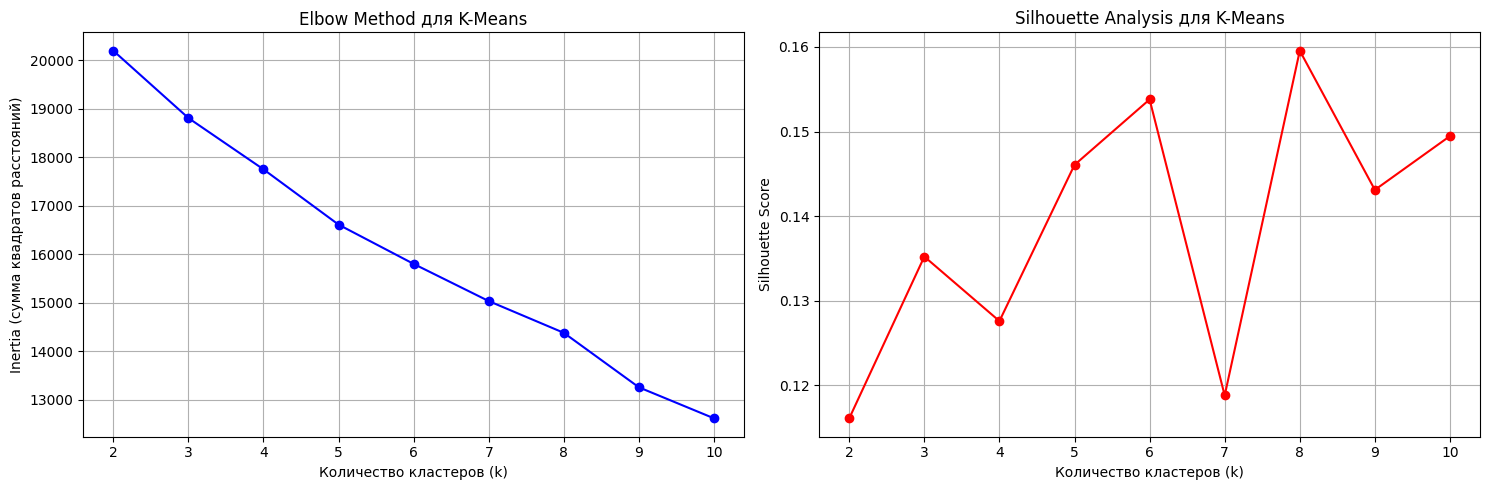

In [230]:
# Диапазон кластеров для тестирования
k_range = range(2, 11)

# Elbow Method
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Графики Elbow + Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('Inertia (сумма квадратов расстояний)')
ax1.set_title('Elbow Method для K-Means')
ax1.grid(True)

# Silhouette Score
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis для K-Means')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [231]:
# Оптимальное k (максимум Silhouette)
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans_best = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_best.fit_predict(X_scaled)
print(f" Оптимальное k для K-Means: {optimal_k} (Silhouette={max(silhouette_scores):.3f})")

 Оптимальное k для K-Means: 8 (Silhouette=0.160)


# Hierarchical Clustering + Dendrogram

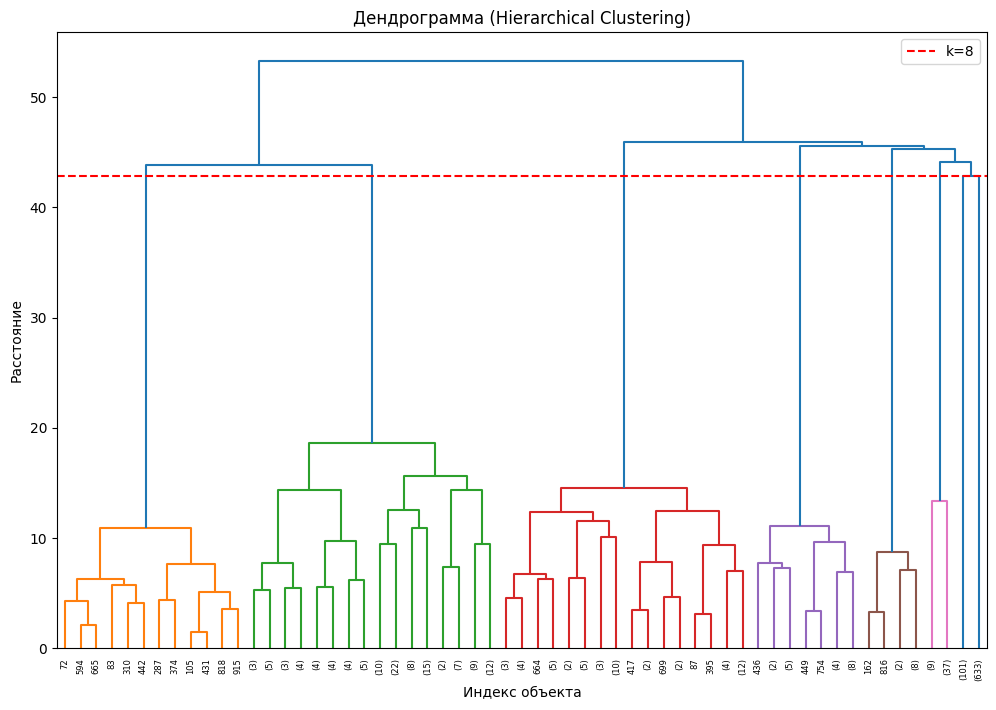

In [232]:
# Агломеративная кластеризация (Ward linkage)
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_labels = model.fit_predict(X_scaled)

# Dendrogram для выбора числа кластеров
plt.figure(figsize=(12, 8))
Z = linkage(X_scaled, 'ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Дендрограмма (Hierarchical Clustering)')
plt.xlabel('Индекс объекта')
plt.ylabel('Расстояние')
plt.axhline(y=Z[-optimal_k+1, 2], c='r', ls='--', label=f'k={optimal_k}')
plt.legend()
plt.show()

In [233]:
n_clusters_hier = len(np.unique(hier_labels))
print(f"Hierarchical: {n_clusters_hier} кластеров")

Hierarchical: 8 кластеров


# DBSCAN

In [234]:
# K-distance для выбора eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 3], axis=0)

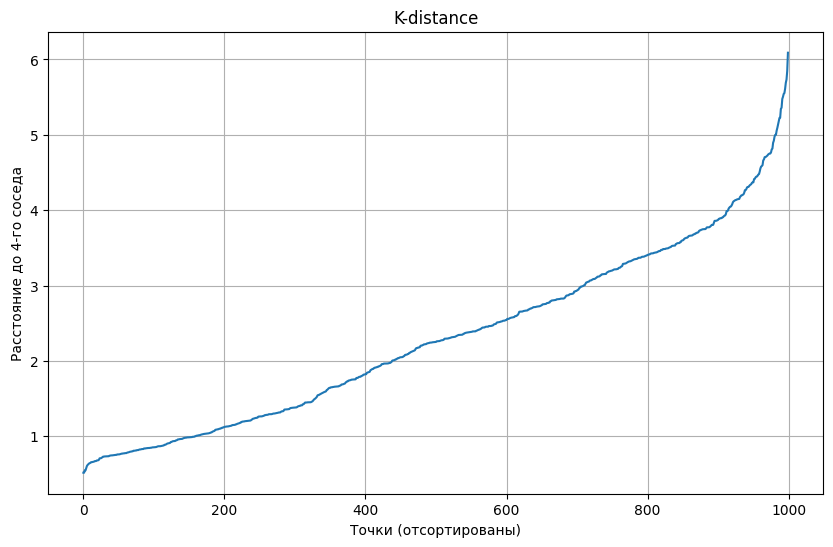

In [235]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance')
plt.xlabel('Точки (отсортированы)')
plt.ylabel('Расстояние до 4-го соседа')
plt.grid(True)
plt.show()

In [236]:
# DBSCAN
eps_values = [0.3, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters >= 2:
        non_noise_mask = labels != -1
        sil_score = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
        print(f"eps={eps}: {n_clusters} кластеров + {n_noise} шума (Silhouette={sil_score:.3f})")
    else:
        print(f"eps={eps}: {n_clusters} кластеров + {n_noise} шума (недостаточно для Silhouette)")

eps=0.3: 0 кластеров + 1000 шума (недостаточно для Silhouette)
eps=0.5: 0 кластеров + 1000 шума (недостаточно для Silhouette)
eps=0.6: 1 кластеров + 995 шума (недостаточно для Silhouette)
eps=0.65: 2 кластеров + 989 шума (Silhouette=0.869)
eps=0.7: 3 кластеров + 976 шума (Silhouette=0.760)
eps=0.8: 10 кластеров + 921 шума (Silhouette=0.530)
eps=0.9: 13 кластеров + 864 шума (Silhouette=0.505)
eps=1.0: 14 кластеров + 822 шума (Silhouette=0.477)


In [237]:
# Лучший eps 0.65 из эксперимента выше

best_eps = 0.65  # из эксперимента выше
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Итоговая статистика
n_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"\nФинальный DBSCAN (eps={best_eps}): {n_clusters} кластеров + {n_noise} шума")


Финальный DBSCAN (eps=0.65): 2 кластеров + 989 шума


# PCA, UMAP, tSNE

In [238]:
methods = {
    'K-Means': kmeans_labels,      # из твоего K-Means
    'Hierarchical': hier_labels,   # из Hierarchical
    'DBSCAN': dbscan_labels        # eps=0.65, 2 кластера
}

In [239]:
# PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [240]:
# UMAP

umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

c:\Users\Anast.Andreeva1\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [241]:
# t-SNE (subsample для скорости)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)  # полный датасет

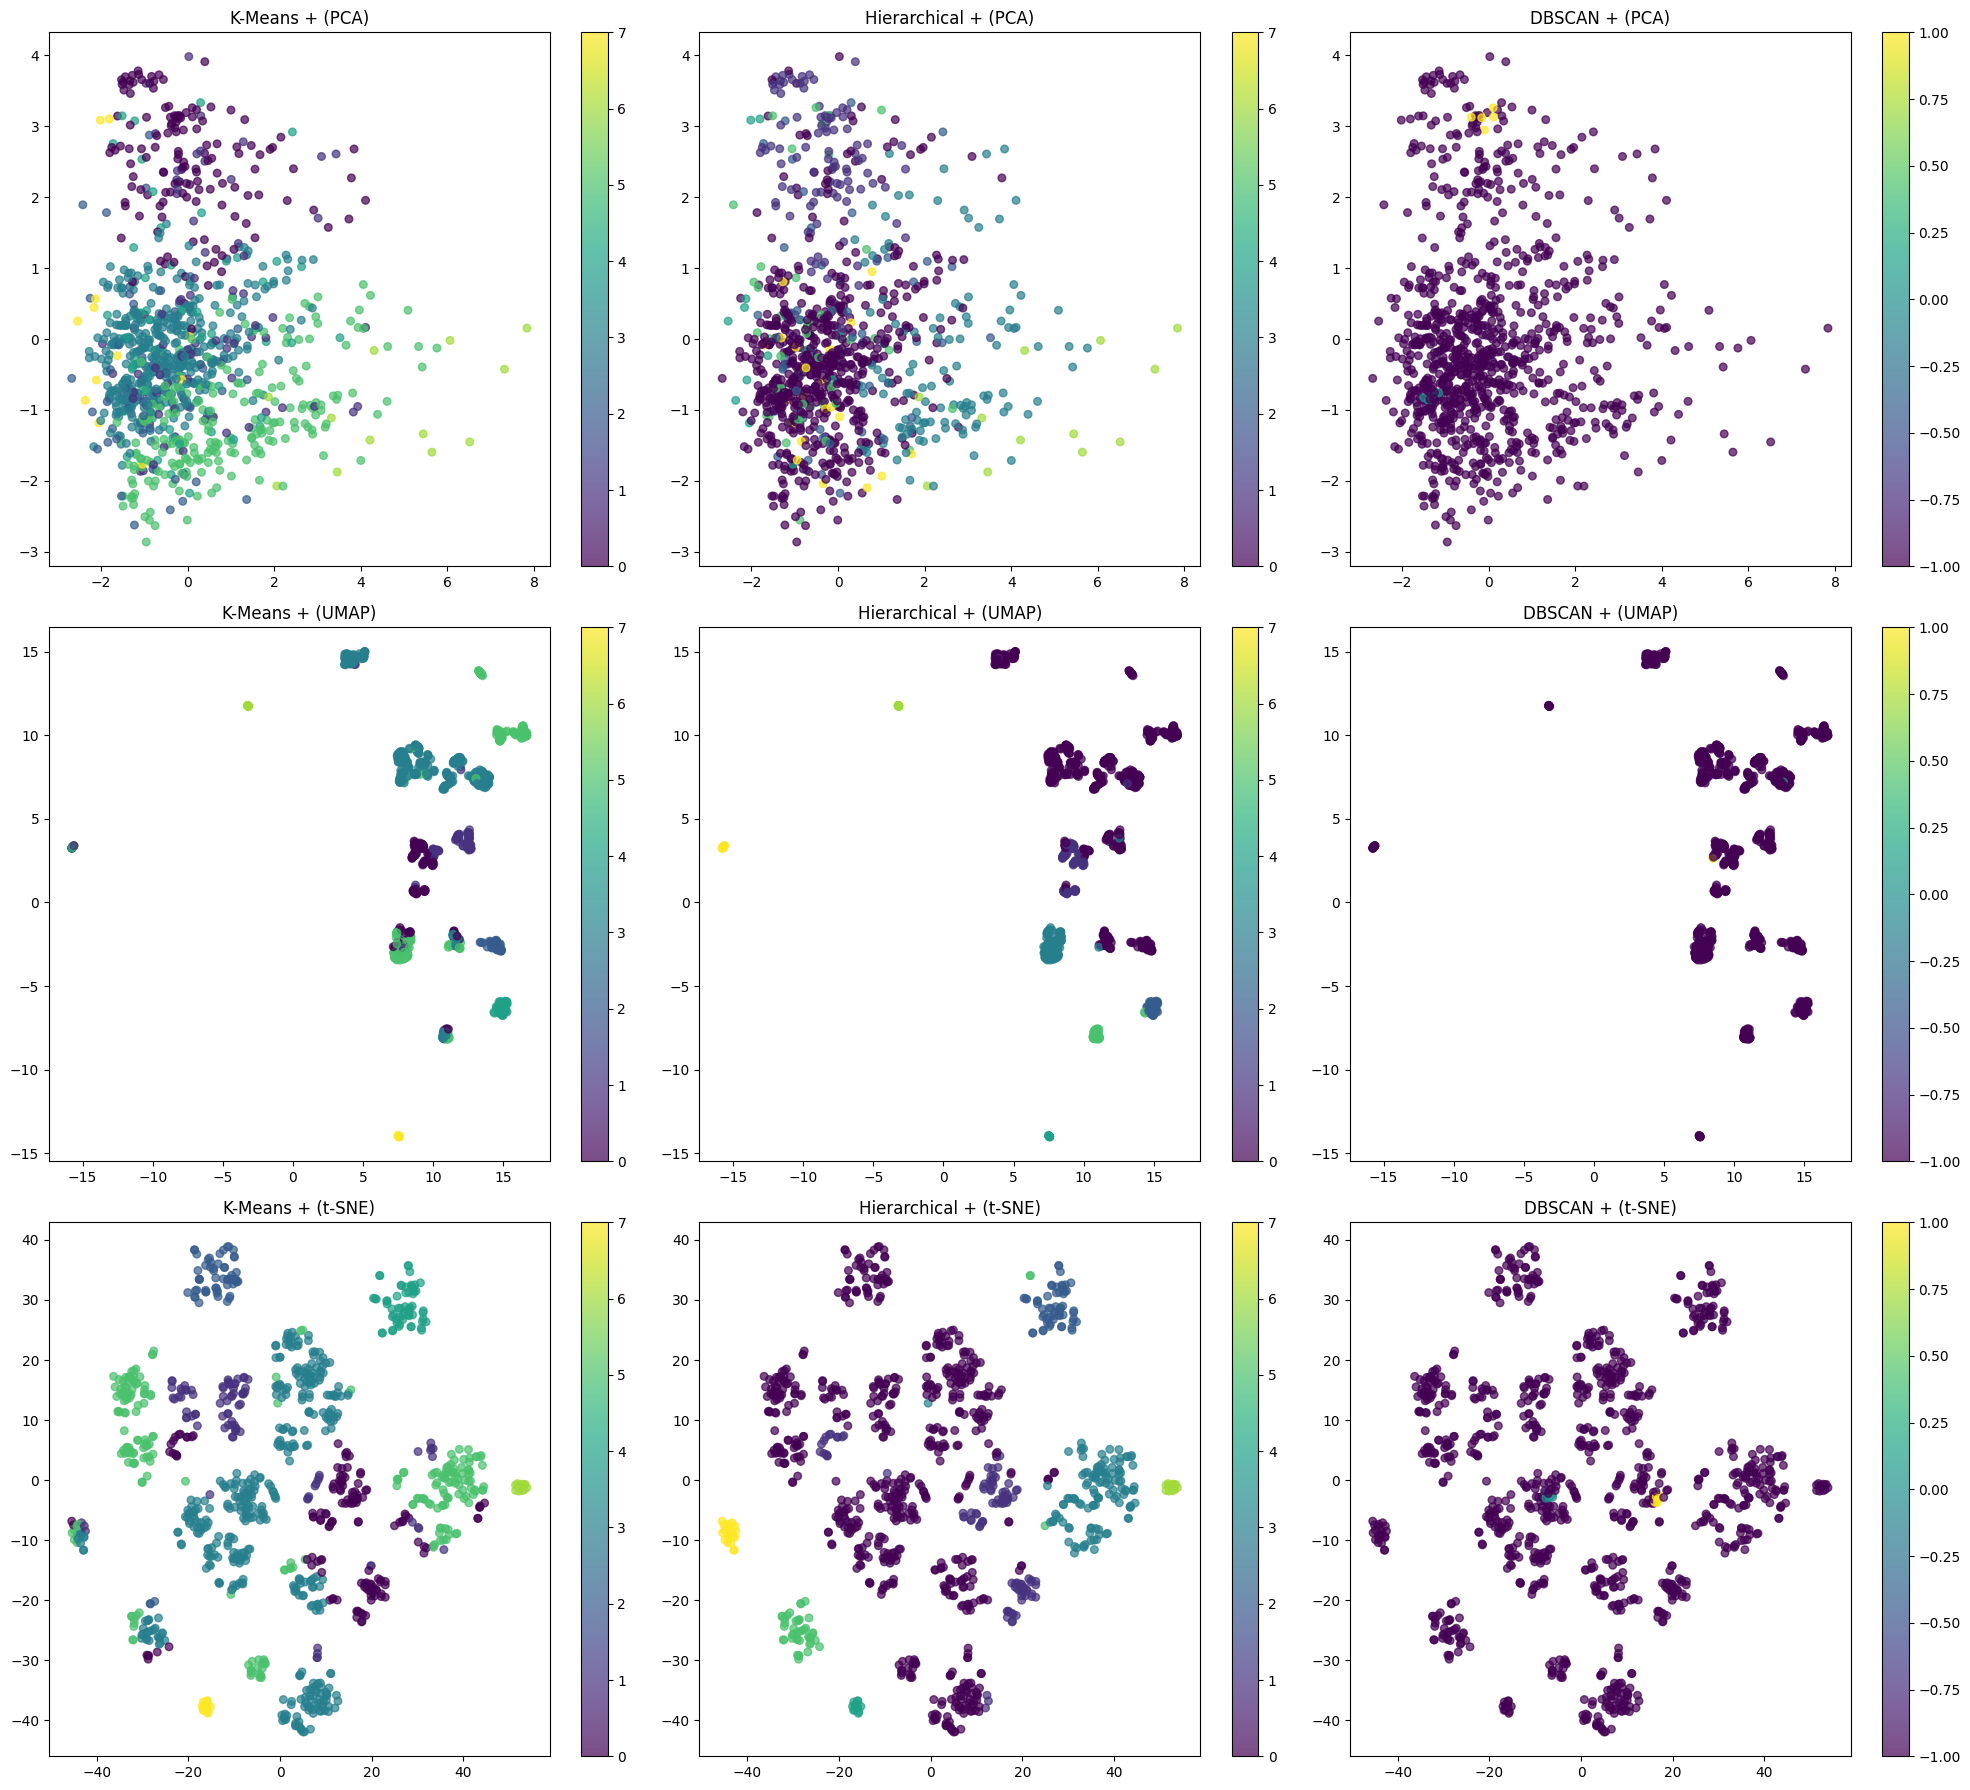

In [242]:
# Визуализация (3x3 = 9 графиков)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.ravel()

reductions = {
    0: ('PCA', X_pca, f"({pca.explained_variance_ratio_.sum():.2f} variance)"),
    3: ('UMAP', X_umap, ''),
    6: ('t-SNE', X_tsne, '(perplexity=30)')
}

method_names = list(methods.keys())

for i, (method_name, labels) in enumerate(methods.items()):
    ax_idx = i
    
    # PCA + метод
    if ax_idx < 3:
        ax = axes[ax_idx]
        scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=30, alpha=0.7)
        ax.set_title(f'{method_name} + (PCA)')
        plt.colorbar(scatter, ax=ax)
    
    # UMAP + метод  
    ax = axes[ax_idx + 3]
    scatter = ax.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='viridis', s=30, alpha=0.7)
    ax.set_title(f'{method_name} + (UMAP)')
    plt.colorbar(scatter, ax=ax)
    
    # t-SNE + метод
    ax = axes[ax_idx + 6]
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='viridis', s=30, alpha=0.7)
    ax.set_title(f'{method_name} + (t-SNE)')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Средние значения по кластерам

In [243]:
# Беру исходные данные ДО One-Hot Encoding (с читаемыми названиями)
# Добавляю метки кластеризации к df_processed

df_analysis = df_processed.copy()
df_analysis['Cluster_KMeans'] = kmeans_labels
df_analysis['Cluster_Hier'] = hier_labels  
df_analysis['Cluster_DBSCAN'] = dbscan_labels

In [245]:
# Средние значения для K-Means
cluster_means_kmeans = df_analysis.groupby('Cluster_KMeans')[['Age', 'Credit amount', 'Duration']].mean()
print("СРЕДНИЕ ЗНАЧЕНИЯ ПО КЛАСТЕРАМ (K-Means):")
print(cluster_means_kmeans.round(2))

СРЕДНИЕ ЗНАЧЕНИЯ ПО КЛАСТЕРАМ (K-Means):
                  Age  Credit amount  Duration
Cluster_KMeans                                
0               30.66        3158.16     19.22
1               32.43        3177.19     22.70
2               37.24        2246.62     17.69
3               35.36        3160.14     22.00
4               38.29        2879.20     19.68
5               38.86        3774.28     20.06
6               39.92        8209.33     32.33
7               34.25        1498.00     16.83


In [246]:
# Средние значения для hier
cluster_means_hier = df_analysis.groupby('Cluster_Hier')[['Age', 'Credit amount', 'Duration']].mean()
print("Hierarchical:")
print(cluster_means_hier.round(2))

Hierarchical:
                Age  Credit amount  Duration
Cluster_Hier                                
0             35.45        2969.40     20.83
1             29.31        2588.02     17.37
2             38.65        2952.70     20.11
3             38.76        5683.53     25.28
4             34.25        1498.00     16.83
5             36.26        2618.61     18.52
6             39.92        8209.33     32.33
7             38.55        2728.09     19.09


In [248]:
# Средние значения для dbscan
cluster_means_dbscan = df_analysis.groupby('Cluster_DBSCAN')[['Age', 'Credit amount', 'Duration']].mean()
print("DBSCAN (только кластеры, без шума):")
print(cluster_means_dbscan[cluster_means_dbscan.index != -1].round(2))

DBSCAN (только кластеры, без шума):
                 Age  Credit amount  Duration
Cluster_DBSCAN                               
0               33.2        1782.20      19.2
1               25.0        1782.67      23.5


In [253]:
""" K-Means и Hierarchical согласуются - есть пересечения: к особо крупным клиентам относится 6 кластер, можно выделить микрокредиты 4(K-Means) и 7(Hierarchical),
    молодые клиенты 30лет, крупные клиенты 6(Hierarchical).
    DBSCAN - делятся на 2 кастера - зрелые клиенты и молодые, при этом молодые берут на срок больше.
"""

' K-Means и Hierarchical согласуются - есть пересечения: к особо крупным клиентам относится 6 кластер, можно выделить микрокредиты 4(K-Means) и 7(Hierarchical),\n    молодые клиенты 30лет, крупные клиенты 6(Hierarchical).\n    DBSCAN - делятся на 2 кастера - зрелые клиенты и молодые, при этом молодые берут на срок больше.\n'

# Boxplot-ы

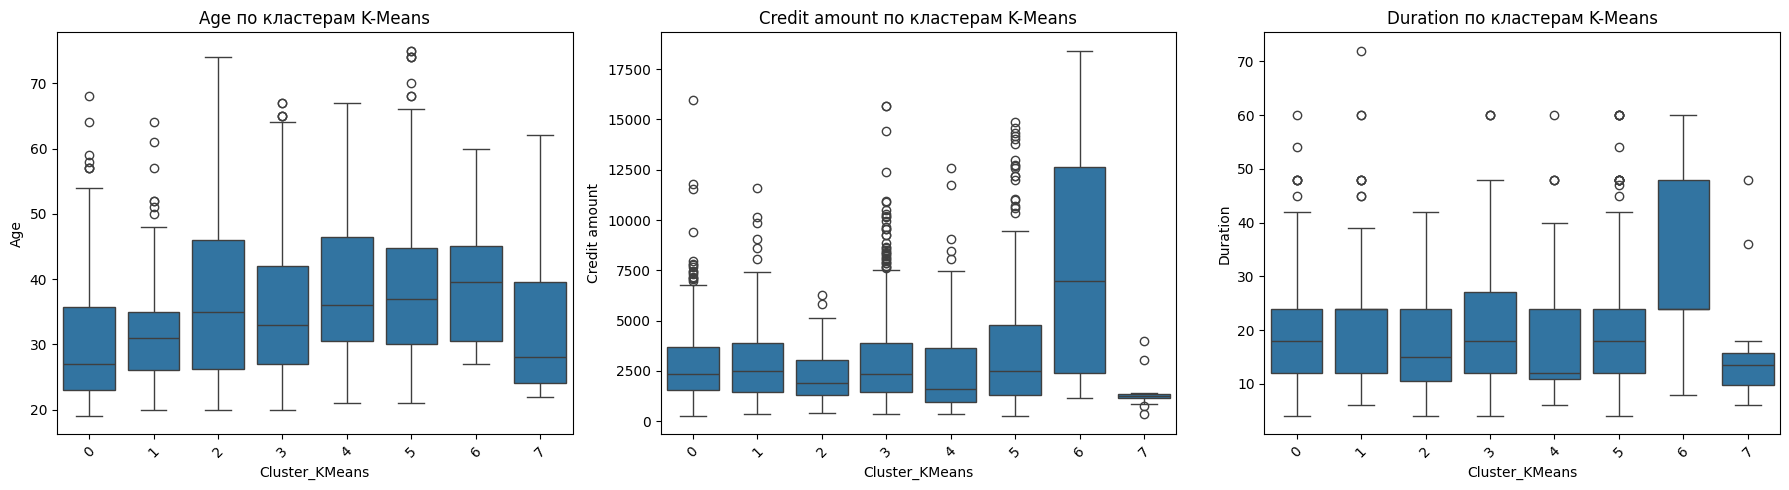

In [249]:
# Boxplot для ключевых числовых признаков (K-Means)
num_features = ['Age', 'Credit amount', 'Duration']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(num_features):
    sns.boxplot(data=df_analysis, x='Cluster_KMeans', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} по кластерам K-Means')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

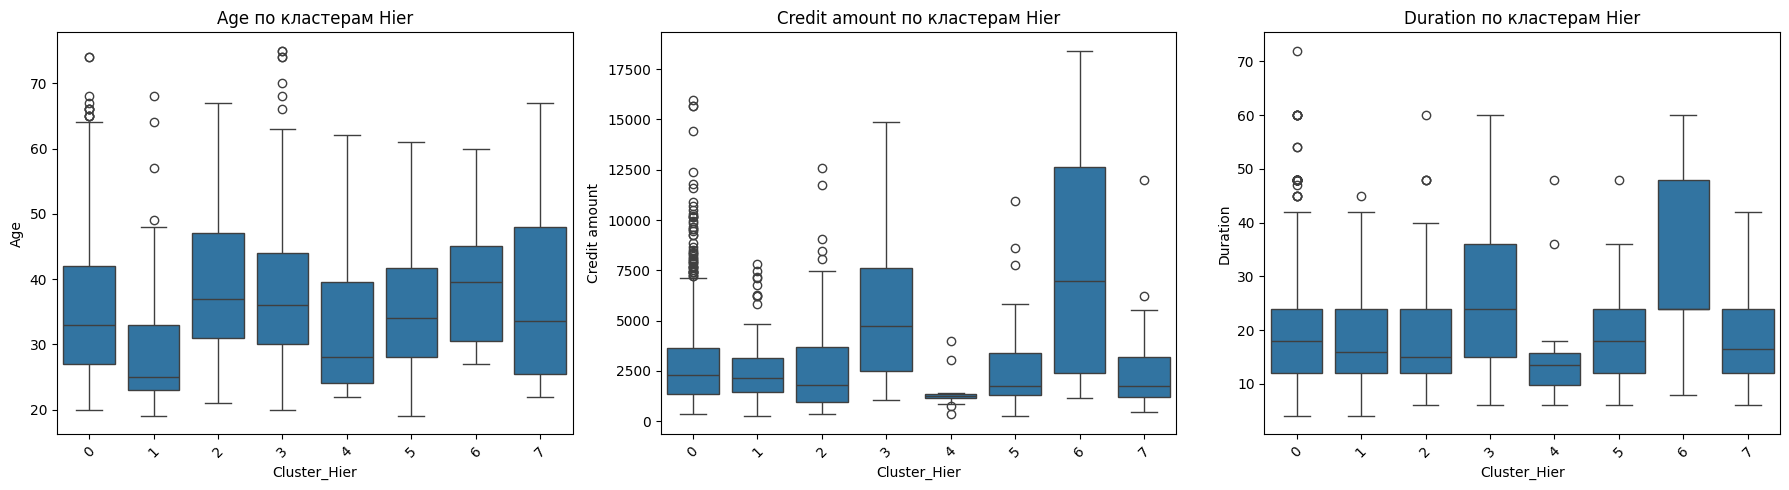

In [250]:
# Boxplot для ключевых числовых признаков (Hier)
num_features = ['Age', 'Credit amount', 'Duration']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(num_features):
    sns.boxplot(data=df_analysis, x='Cluster_Hier', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} по кластерам Hier')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

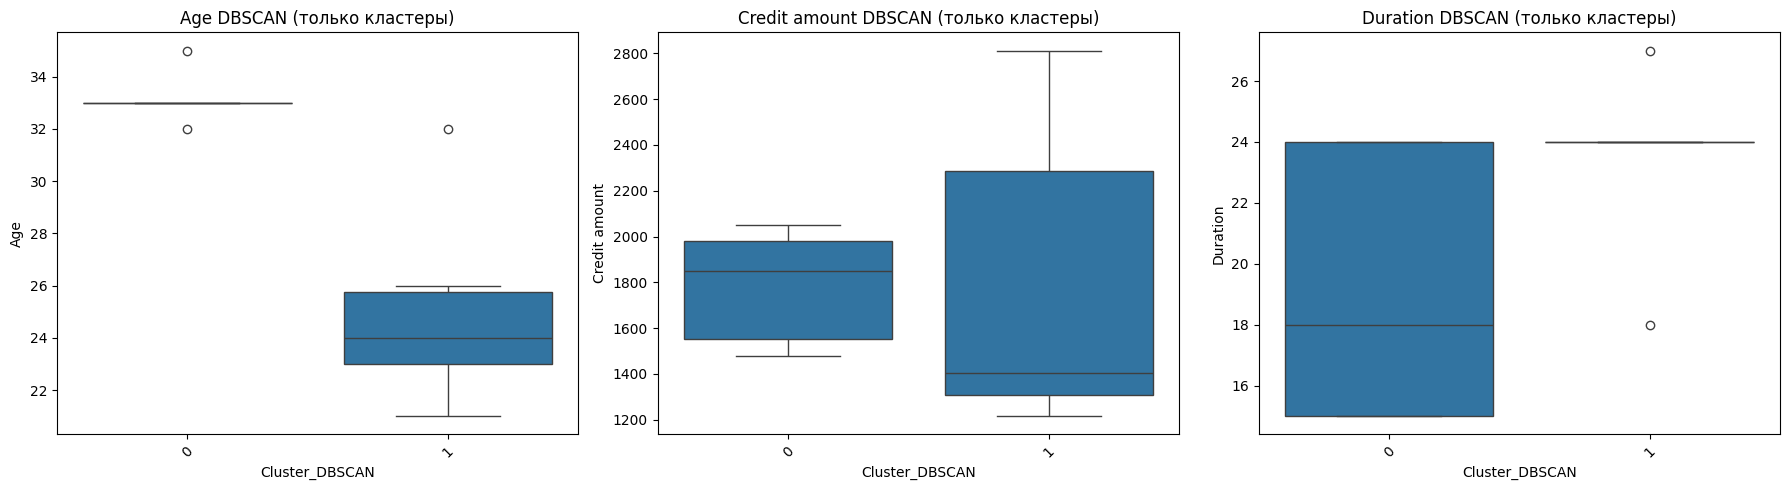

In [252]:
# Boxplot для ключевых числовых признаков (DBSCAN, без шума)

df_dbscan_clean = df_analysis[df_analysis['Cluster_DBSCAN'] != -1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
num_features = ['Age', 'Credit amount', 'Duration']

for i, feature in enumerate(num_features):
    sns.boxplot(data=df_dbscan_clean, x='Cluster_DBSCAN', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} DBSCAN (только кластеры)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
""" 
Сумма кредита - межквартильный размах в кластере 6 (K-Means и Hierarchical) значительно выше - широкий прямоугольник. Выбросы и максимумы резко отличаются.
Credit amount - основной фактор разделения кластеров.
Срок кредита - медианы находятся на разных уровнях, но не так резко как Credit amount.
Срок кредита - вспомогательный, но значимый признак
Срк кредита коррелирует с размером кредита - большие кредиты на долгий срок.
Возраст меньше влияет на кластеризацию - возраст не главный критерий. Медианы расположены близко друг к другу.
Три алгоритма (K-Means, Hierarchical, DBSCAN) согласуются - надёжная сегментация 
"""